In [29]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [56]:
fpath = 'facebook_data_WSJ_comments_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,CommentID,CommentDate,CommenterURL,CommentText,WNPositive,WNNegative,WNNeutral,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,0,1.016109e+16,2021-05-16 19:01:00,10161086225983128,NaN,papilo.danlami?fref=nf&rc=p&refid=52&__tn__=R,Thanks you so much Mr Benjamin Franklin you ma...,7.925,0.900,32.175,...,40,0.350000,4,0,40,0.100000,0.302,0.000,0.698,0.9868
1,1,1.016109e+16,2021-05-16 18:35:00,10161085607653128,NaN,tara.dawn.77985741?fref=nf&rc=p&refid=52&__tn...,How come we don't hear about tewatment advance...,0.875,1.375,18.750,...,30,0.200000,1,0,30,0.033333,0.111,0.033,0.856,0.6378
2,2,1.016109e+16,2021-05-16 18:35:00,10161085614898128,NaN,brenda.gustafson.7?fref=nf&rc=p&refid=52&__tn...,Kimmel would be the last person I’d listen to ...,0.000,0.250,2.750,...,3,0.000000,0,0,3,0.000000,0.000,0.000,1.000,0.0000
3,3,1.016109e+16,2021-05-16 18:35:00,10161087595503128,NaN,june.park.908?fref=nf&rc=p&refid=52&__tn__=R,EUA doesn't legally allow ads. Makes me wonder...,0.500,1.625,2.875,...,10,0.200000,0,0,10,0.000000,0.000,0.378,0.622,-0.7574
4,4,1.016109e+16,2021-05-16 18:35:00,10161085955568128,NaN,jane.carbonneau?fref=nf&rc=p&refid=52&__tn__=R,Won't change people's opinions of the jab if t...,0.125,0.625,2.250,...,6,-0.166667,0,0,6,0.000000,0.000,0.000,1.000,0.0000


In [57]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

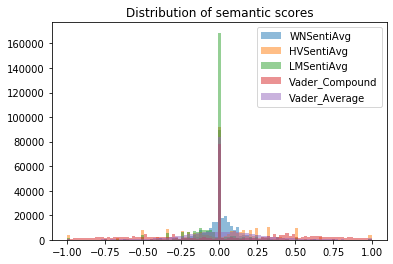

In [58]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

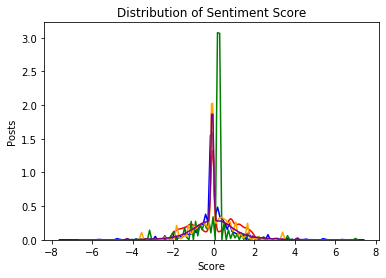

In [59]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [63]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,279703.000000,279703.000000,279703.000000,279703.000000,279703.000000
mean,0.013249,0.021218,-0.036249,0.025133,0.015791
std,0.135025,0.286967,0.147291,0.477375,0.237976
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.025000,-0.090909,-0.062500,-0.318200,-0.080000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.053571,0.157895,0.000000,0.401900,0.117000
max,1.000000,1.000000,1.000000,0.999900,1.000000


In [68]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [65]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [66]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'CommentID', 'CommentDate', 'CommenterURL',
       'CommentText', 'WNPositive', 'WNNegative', 'WNNeutral', 'WNSentiment',
       'WNTokenQnt', 'WNSentiAvg', 'HVPositive', 'HVNegative', 'HVTokenQnt',
       'HVSentiAvg', 'LMPositive', 'LMNegative', 'LMTokenQnt', 'LMSentiAvg',
       'Vader_Positive', 'Vader_Negative', 'Vader_Neutral', 'Vader_Compound',
       'Vader_Average', 'DateMonth', 'DateDay'],
      dtype='object')

In [69]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [70]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [71]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [41]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -24.3756
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    845.0000
Critical Value (1%)             -3.4381
Critical Value (5%)             -2.8650
Critical Value (10%)            -2.5686
dtype: float64


In [42]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -25.3269
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    845.0000
Critical Value (1%)             -3.4381
Critical Value (5%)             -2.8650
Critical Value (10%)            -2.5686
dtype: float64


In [43]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                 -25.3269
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    845.0000
Critical Value (1%)             -3.4381
Critical Value (5%)             -2.8650
Critical Value (10%)            -2.5686
dtype: float64
Results of Dickey-Fuller Test:


In [44]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -7.1460
p-value                          0.0000
#Lags Used                       7.0000
Number of Observations Used    838.0000
Critical Value (1%)             -3.4382
Critical Value (5%)             -2.8650
Critical Value (10%)            -2.5686
dtype: float64
Results of Dickey-Fuller Test:


In [45]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2011-01-14,1.288790,25,0.070728,0.091040,31,33,227,5,14,227,0.051552,-0.008811,-0.039648
2011-01-18,5.169719,66,0.132435,0.125561,168,127,782,20,57,782,0.078329,0.052430,-0.047315
2011-01-19,1.677604,55,0.160760,0.079945,128,65,542,16,22,542,0.030502,0.116236,-0.011070
2011-01-20,2.960898,105,0.070618,0.016610,286,180,1278,27,90,1278,0.028199,0.082942,-0.049296
2011-01-21,0.525784,91,0.037033,0.046527,134,84,701,16,38,701,0.005778,0.071327,-0.031384


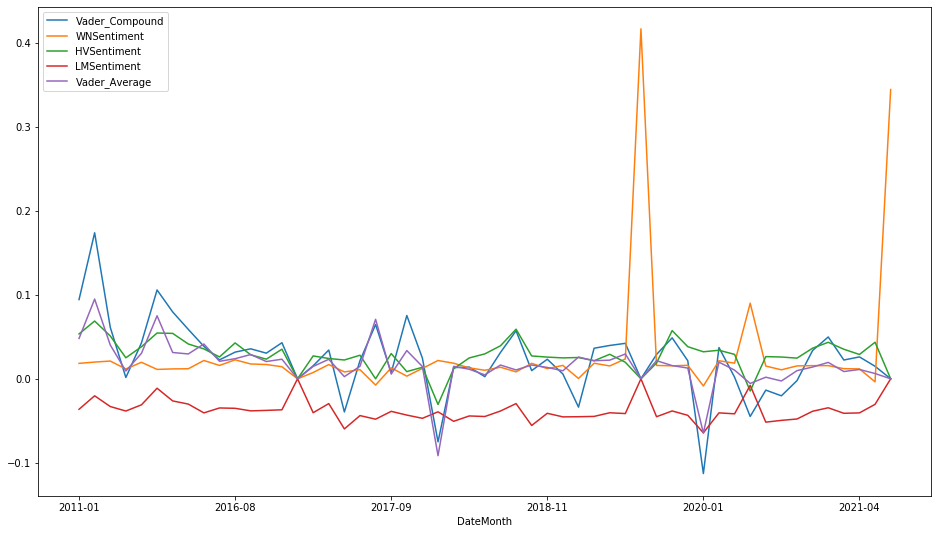

In [72]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [47]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/^GSPC/history?period1=1285894800&period2=1619917199&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [48]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [20]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [21]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [73]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [50]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [74]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [52]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [53]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2011-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995,0.022393,18.471209,1005,0.094308,0.048027,2158,1557,11252,268,676,11252,0.018379,0.053413,-0.036260
2011-02,1344.069946,1289.140015,1289.140015,1327.219971,59223660000,1327.219971,0.031457,5.495790,276,0.173830,0.094899,658,427,3360,84,152,3360,0.019912,0.068750,-0.020238
2015-09,2020.859985,1871.910034,1970.089966,1920.030029,79989370000,1920.030029,-0.026799,82.584238,3909,0.061376,0.040255,7723,5605,41506,1034,2404,41506,0.021127,0.051029,-0.033007
2015-11,2116.479980,2019.390015,2080.760010,2080.409912,75943590000,2080.409912,0.000505,41.530031,3550,0.001519,0.009277,6797,5817,39183,921,2424,39183,0.011699,0.025011,-0.038358
2015-12,2104.270020,1993.260010,2082.929932,2043.939941,83649260000,2043.939941,-0.017686,125.730949,6398,0.042814,0.030353,12641,9941,70720,1833,4023,70720,0.019652,0.038179,-0.030967
2016-01,2038.199951,1812.290039,2038.199951,1940.239990,92409770000,1940.239990,-0.052068,0.861320,77,0.105748,0.075000,102,68,624,22,29,624,0.011186,0.054487,-0.011218
2016-02,1962.959961,1810.099976,1936.939941,1932.229980,93049560000,1932.229980,-0.004137,37.485882,3182,0.079599,0.031295,8626,6124,46293,1208,2427,46293,0.011781,0.054047,-0.026332
2016-03,2072.209961,1937.089966,1937.089966,2059.739990,92639420000,2059.739990,0.063905,85.439538,7143,0.058854,0.029581,18673,14343,104499,2735,5880,104499,0.011961,0.041436,-0.030096
2016-05,2103.479980,2025.910034,2067.169922,2096.949951,78883600000,2096.949951,0.015208,57.183743,2624,0.038631,0.041418,6137,4886,35155,803,2229,35155,0.021793,0.035585,-0.040563
2016-06,2120.550049,1991.680054,2093.939941,2098.860107,86852700000,2098.860107,0.000911,118.796138,7471,0.022510,0.020843,16056,13212,109243,1995,5786,109243,0.015901,0.026034,-0.034702


In [75]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound

Optimal number of lags for exog data is 2


C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1739  , p=0.6768  , df_denom=567, df_num=1
ssr based chi2 test:   chi2=0.1748  , p=0.6759  , df=1
likelihood ratio test: chi2=0.1748  , p=0.6759  , df=1
parameter F test:         F=0.1739  , p=0.6768  , df_denom=567, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5255  , p=0.5915  , df_denom=564, df_num=2
ssr based chi2 test:   chi2=1.0604  , p=0.5885  , df=2
likelihood ratio test: chi2=1.0594  , p=0.5888  , df=2
parameter F test:         F=0.5255  , p=0.5915  , df_denom=564, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4800  , p=0.6963  , df_denom=561, df_num=3
ssr based chi2 test:   chi2=1.4581  , p=0.6920  , df=3
likelihood ratio test: chi2=1.4562  , p=0.6924  , df=3
parameter F test:         F=0.4800  , p=0.6963  , df_denom=561, df_num=3

Grang

Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1420  , p=0.2857  , df_denom=567, df_num=1
ssr based chi2 test:   chi2=1.1480  , p=0.2840  , df=1
likelihood ratio test: chi2=1.1468  , p=0.2842  , df=1
parameter F test:         F=1.1420  , p=0.2857  , df_denom=567, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9769  , p=0.3771  , df_denom=564, df_num=2
ssr based chi2 test:   chi2=1.9712  , p=0.3732  , df=2
likelihood ratio test: chi2=1.9678  , p=0.3739  , df=2
parameter F test:         F=0.9769  , p=0.3771  , df_denom=564, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4876  , p=0.6910  , df_denom=561, df_num=3
ssr based chi2 test:   chi2=1.4811  , p=0.6866  , df=3
likelihood ratio test: chi2=1.4791  , p=0.6871  , df=3
parameter F test:         F=0.4876  , p=0.6910  , df_denom=561, df_num=3

Grang

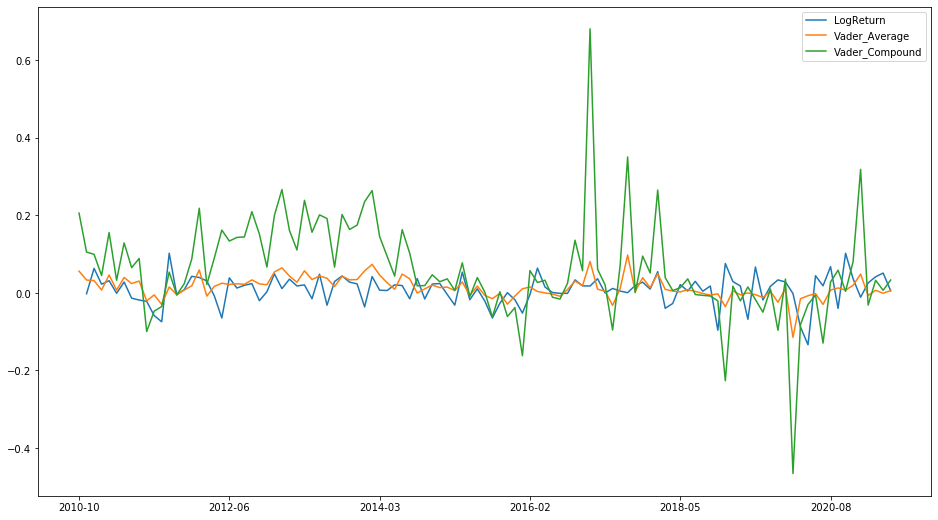

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [34]:
corr = Granger_data_daily[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average', 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Flair_Score,SentimentScoreAdj,Vader_Average,LogReturn
Vader_Compound,1.000000,0.237375,0.421607,0.904405,0.024251
Flair_Score,0.237375,1.000000,0.126345,0.236614,0.024030
SentimentScoreAdj,0.421607,0.126345,1.000000,0.378771,0.019746
Vader_Average,0.904405,0.236614,0.378771,1.000000,0.023152
LogReturn,0.024251,0.024030,0.019746,0.023152,1.000000


In [55]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.835469
Vader_Average   0.817057
WNSentiment     0.954668
HVSentiment     0.472921
LMSentiment     0.099942


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
